# Practical Activity 1 (**PRA1**)

## Evaluable Practical Exercise

<u>General considerations</u>:

- The proposed solution cannot use methods, functions or parameters declared **_deprecated_** in future versions.
- This activity must be carried out on a **strictly individual** basis. Any indication of copying will be penalized with a failure for all parties involved and the possible negative evaluation of the subject in its entirety.
- It is necessary for the student to indicate **all the sources** that she/he has used to carry out the PRA. If not, the student will be considered to have committed plagiarism, being penalized with a failure and the possible negative evaluation of the subject in its entirety.

<u>Delivery format</u>:

- Some exercises may require several minutes of execution, so the delivery must be done in **Notebook format** and in **HTML format**, where the code, results and comments of each exercise can be seen. You can export the notebook to HTML from the menu File $\to$ Download as $\to$ HTML.
- There is a special type of cell to hold text. This type of cell will be very useful to answer the different theoretical questions posed throughout the activity. To change the cell type to this type, in the menu: Cell $\to$ Cell Type $\to$ Markdown.

<div class="alert alert-block alert-info">
<strong>Name and surname:</strong>
</div>

## Introduction

The [Fashion MNIST](https://keras.io/api/datasets/fashion_mnist/) dataset provided by Zalando consists of 70,000 images with 10 different classes of clothing spread evenly.

The F-MNIST database contains 60,000 training images and 10,000 testing images. The images have a resolution of 28x28 pixels in grayscale, so they can be represented using a 784 position vector.

There are four parts in this activity:
1. Supervised learning with the whole dataset
2. Supervised learning with a subset
3. Self-training
4. Cluster-then-label method

## Required libraries and dataset

Fisrt of all, load the required libraries and the F-MNIST dataset.

<u>Questions</u>:
- Load the [Fashion MNIST](https://keras.io/api/datasets/fashion_mnist/) dataset.
- Plot one example for each class (or label)

**Notes**:
- You can use the `keras` library or load it directly from CSV or Pickle files.

In [1]:
!pip install torcheval

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torcheval #https://pytorch.org/torcheval/stable/
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import ConfusionMatrixDisplay#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
from torcheval.metrics.functional import multiclass_f1_score

In [3]:
#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train = torchvision.datasets.FashionMNIST("data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
validation = datasets.FashionMNIST("data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

In [5]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader =  torch.utils.data.DataLoader(validation, batch_size=batch_size, shuffle=True)

In [6]:
all_classes =list(range(len(train.classes)))
img_lis = []
for img, cat in train:
  if all_classes == []:
    break

  elif cat in all_classes:
    img_lis.append((img, cat))
    all_classes.remove(cat)

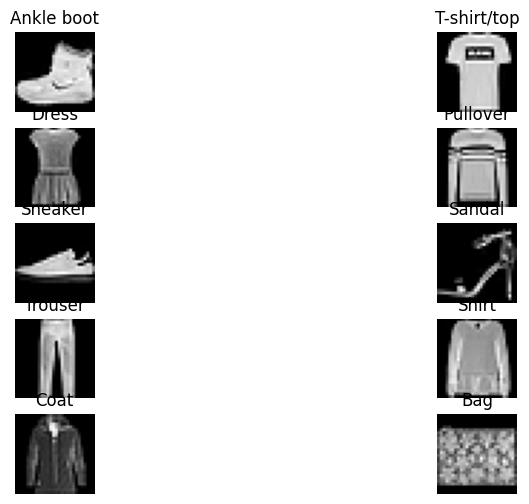

In [7]:
rows = 5
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10, 6))

for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        if index < len(img_lis):
            axes[i, j].imshow(img_lis[index][0].squeeze(0), cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title(train.classes[img_lis[index][1]])

## Part 1. Supervised learning with the whole dataset

This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images.

<u>Questions</u> (**2 points**):
1. **Split the dataset** into _train_ and _test_ subsets (60,000 images for _train_, and 10,000 for _test_)
2. Create a Convolutional Neural Network (**CNN**) with the following architecture:
- Convolutional layer (16 kernels, 5x5, ReLU activation
- Max pooling 2x2
- Fully-connected layer (10 neurons, Softmax activation)
3. **Train** this network with the whole _train_ subset with the following parameters:
- SGD optimizer
- Batch size equal to 100
- Number of epochs equal to 5
4. Provide (at least) the following **metrics** using the _test_ dataset:
- Accuracy
- F1 Score
- Confusion matrix

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features = 12*12*16, out_features  = 10)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size = 5),#24x24x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),#12x12x16

        )


    def forward(self, x):
        batch_size = x.shape[0]
        x = self.encoder(x)

        x = x.view(batch_size,-1)

        x = self.fc1(x)

        return x

In [9]:
model = CNN().to(device)


optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()

In [10]:
def model_train(model, loader, optimizer, criterion, reshape=False):
    loss = 0
    model.train()

    for batch_features, labels in loader:
        # load it to the active device
        batch_features = batch_features.to(device)
        labels = labels.to(device)

        # reset the gradients back to zero
        optimizer.zero_grad()

        # compute predictions
        outputs = model(batch_features)

        # compute training loss
        train_loss = criterion(outputs, labels)

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))

def model_test(model, loader, criterion, reshape=False):
    loss = 0
    model.eval()
    tot_pred_labels = torch.tensor([]).to(device)
    tot_true_labels = torch.tensor([]).to(device)

    for batch_features, labels in loader:
        batch_features = batch_features.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(batch_features)
        pred_labels = torch.argmax(outputs, dim = 1)
        true_labels = labels
        tot_pred_labels = torch.cat((tot_pred_labels, pred_labels), dim = 0)
        tot_true_labels = torch.cat((tot_true_labels, true_labels), dim = 0)
        # compute training loss
        test_loss = criterion(outputs,labels)

        # add the batch training loss to epoch loss
        loss += test_loss.item()

    # compute the epoch test loss
    loss = loss / len(loader)

    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    return tot_pred_labels,tot_true_labels


In [11]:
epochs=5
for epoch in range(epochs):
    model_train(model, train_loader, optimizer, criterion, reshape=True)
    tot_pred_labels,tot_true_labels = model_test(model, val_loader, criterion, reshape=True)

epoch : 1/5, Train loss = 1.816639
epoch : 1/5, Test loss = 1.340940
epoch : 2/5, Train loss = 1.077545
epoch : 2/5, Test loss = 0.927110
epoch : 3/5, Train loss = 0.839258
epoch : 3/5, Test loss = 0.798680
epoch : 4/5, Train loss = 0.749092
epoch : 4/5, Test loss = 0.736420
epoch : 5/5, Train loss = 0.699298
epoch : 5/5, Test loss = 0.696645


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
num_correct_preds = torch.sum(torch.eq(tot_true_labels,tot_pred_labels)).item()
accuracy_60000 = num_correct_preds/len(tot_true_labels)
precision_60000 = precision_score(tot_true_labels.cpu(), tot_pred_labels.cpu(), average='weighted')
recall_60000 = recall_score(tot_true_labels.cpu(), tot_pred_labels.cpu(), average='weighted')
f1_score_60000 = multiclass_f1_score(tot_pred_labels,tot_true_labels)
confusion_60000 = confusion_matrix(tot_true_labels.cpu(),tot_pred_labels.cpu() )

In [13]:
print("Accuracy:", accuracy_60000)
print("Precision:", precision_60000)
print("Recall:", recall_60000)
print("F1 score: ", f1_score_60000.cpu().item())

print(confusion_60000)

Accuracy: 0.7578
Precision: 0.7514228841522157
Recall: 0.7578
F1 score:  0.7577999830245972
[[765  11   8 105   8   8  80   1  13   1]
 [  7 906  11  53  14   0   7   0   2   0]
 [  8   3 613  13 194   5 144   0  20   0]
 [ 27  20   0 837  35   2  75   0   4   0]
 [  0   5 207  62 648   7  61   0  10   0]
 [  0   1   0   2   0 814   0 130   6  47]
 [203   5 188  70 175  23 307   0  29   0]
 [  0   0   0   0   0  59   0 865   0  76]
 [  1   2  14  22   4  18  24  13 901   1]
 [  0   0   0   2   0  17   0  58   1 922]]


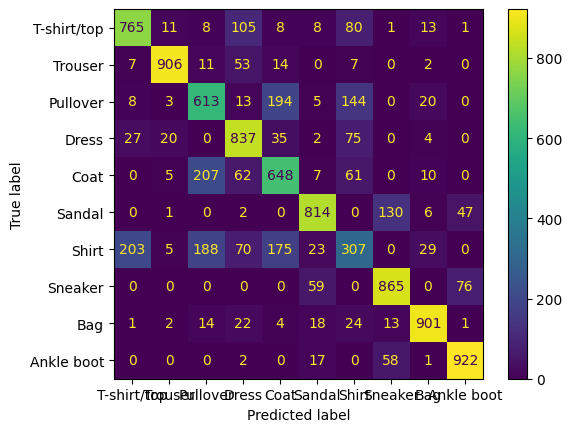

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_60000,display_labels=validation.classes)
disp.plot()

## Part 2. Supervised learning with a subset

In this exercise, we will split the _train_ dataset into two subsets:
- The first subset, denoted by $D_L$, will be the labelled dataset. It will contain 10,000 images with their labels.
- The second one, denoted by $D_U$, will be used as unlabelled data. It will contain 50,000 images without labels. However, you have to store their labels and keep them for subsequent exercises.

<u>Questions</u> (**1 point**):
1. Split the _train_ dataset as previously described.
2. Create and train a CNN with the architecture and parameters indicated in the previous exercise.
3. Report the same evaluation metrics
4. Compare the results and justify them.

**Notes**:
- Use the `train_test_split`function with `random_state=1234`.

In [15]:
from sklearn.model_selection import train_test_split #https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [16]:
D_Labeled, D_Unlabeled_data = train_test_split(train, test_size=50000/60000, train_size = 10000/60000,random_state=1234)

In [17]:
D_Unlabeled = [img[0] for img in D_Unlabeled_data]
D_Unlabled_labels = [label[1] for label in D_Unlabeled_data]

In [18]:
print("number of labeled samples:",len(D_Labeled))
print("number of unlabeled samples:", len(D_Unlabeled))

number of labeled samples: 10000
number of unlabeled samples: 50000


In [19]:
batch_size = 100
D_Labeled_loader = torch.utils.data.DataLoader(D_Labeled, batch_size=batch_size, shuffle=True)
val_loader =  torch.utils.data.DataLoader(validation, batch_size=batch_size, shuffle=True)

In [20]:
D_Unlabeled_loader = torch.utils.data.DataLoader(D_Unlabeled_data , batch_size=batch_size, shuffle=True)

In [21]:
model_subset = CNN().to(device)


optimizer = torch.optim.SGD(model_subset.parameters(), lr=1e-3)


criterion = nn.CrossEntropyLoss()

In [22]:
epochs=5
for epoch in range(epochs):
    model_train(model_subset, D_Labeled_loader, optimizer, criterion, reshape=True)
    tot_pred_labels,tot_true_labels = model_test(model_subset, val_loader, criterion, reshape=True)

epoch : 1/5, Train loss = 2.251864
epoch : 1/5, Test loss = 2.205744
epoch : 2/5, Train loss = 2.151506
epoch : 2/5, Test loss = 2.104968
epoch : 3/5, Train loss = 2.039334
epoch : 3/5, Test loss = 1.983752
epoch : 4/5, Train loss = 1.904105
epoch : 4/5, Test loss = 1.839086
epoch : 5/5, Train loss = 1.748829
epoch : 5/5, Test loss = 1.680142


In [23]:
num_correct_preds = torch.sum(torch.eq(tot_true_labels,tot_pred_labels)).item()
accuracy_10000 = num_correct_preds/len(tot_true_labels)
precision_10000 = precision_score(tot_true_labels.cpu(), tot_pred_labels.cpu(), average='weighted')
recall_10000 = recall_score(tot_true_labels.cpu(), tot_pred_labels.cpu(), average='weighted')
f1_score_10000 = multiclass_f1_score(tot_pred_labels,tot_true_labels)
confusion_10000 = confusion_matrix(tot_true_labels.cpu(),tot_pred_labels.cpu() )

In [24]:
print("Accuracy:", accuracy_10000)
print("Precision:", precision_10000)
print("Recall:", recall_10000)
print("F1 score: ", f1_score_10000.cpu().item())

print(confusion_10000)

Accuracy: 0.5751
Precision: 0.6300371556691248
Recall: 0.5751
F1 score:  0.5751000046730042
[[758  72  51  45  55   0   4   1  12   2]
 [  1 944   8  10  35   0   0   0   2   0]
 [  7   5 348   5 619   0   5   0   9   2]
 [ 26 603   6 218 144   0   1   1   1   0]
 [  2  38  51  25 875   0   3   0   5   1]
 [  1   1   0   0   0   4   0 481  11 502]
 [198  32 116  42 570   0  17   0  24   1]
 [  0   0   0   0   0   1   0 817   0 182]
 [  6   6  57  20  73   0   0  35 799   4]
 [  0   0   0   0   0   0   0  28   1 971]]


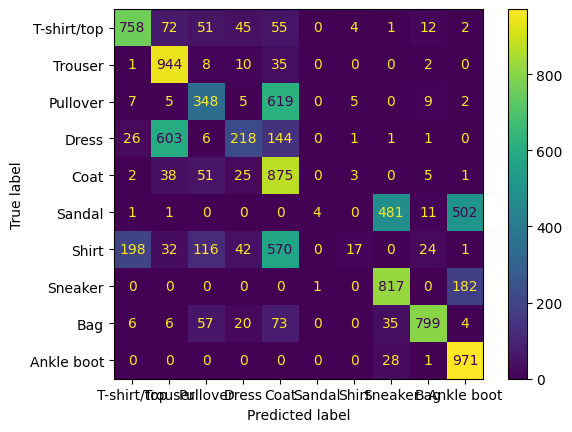

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_10000,display_labels=validation.classes)
disp.plot()

#Results explanation

Results obtained training with the full labled dataset(60000 images)

Accuracy: 0.7578
Precision: 0.7514228841522157
Recall: 0.7578
F1 score:  0.7577999830245972


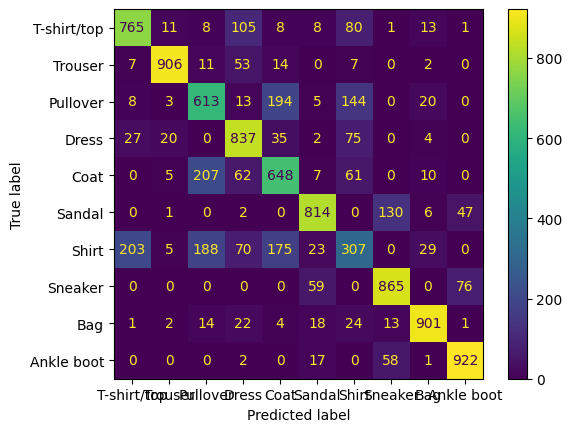

In [26]:
print("Accuracy:", accuracy_60000)
print("Precision:", precision_60000)
print("Recall:", recall_60000)
print("F1 score: ", f1_score_60000.cpu().item())

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_60000,display_labels=validation.classes)
disp.plot()

Results obtained training with a subset of 10000 labled samples

Accuracy: 0.5751
Precision: 0.6300371556691248
Recall: 0.5751
F1 score:  0.5751000046730042


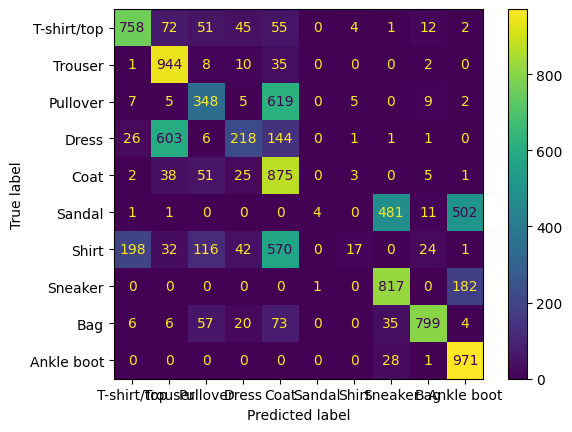

In [27]:
print("Accuracy:", accuracy_10000)
print("Precision:", precision_10000)
print("Recall:", recall_10000)
print("F1 score: ", f1_score_10000.cpu().item())

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_10000,display_labels=validation.classes)
disp.plot()

 The model trained with 60000 samples is clearly better in all the metrics by a 10% difference, or a percentage increase of a 25% aproximately. This is because because it has more data and it can learn more features or caracteristics of every class in the data, generalizing better for new unseen samples.

 On the other hand with only 10000 samples the model let some important features out, struggling to distinguish classes like sandal or shirt, where it only classified 23 and 28 samples correctly respectively. In the Shirt case it is doing logic confusions with other similar classes like T-shirt or coat. This let us think that we are in a case of underfitting, because with more samples it can learn more features being able to distinguish between this similar classes.

 To conclude, the model with 10000 sample obtain worst results because it need more data to learn meaningfull features for classification



## Part 3. Self-training

Self-training methods (sometimes also called _self-learning_ methods) are the most basic of pseudo-labelling approaches. They consist of a **single supervised classifier** that is iteratively trained on both **labelled** data and data that has been **pseudo-labelled** in previous iterations of the algorithm.

Self-training procedure:
- At the beginning of the self-training procedure, **a supervised classifier is trained on only the labelled data**.
- The resulting classifier is used to **obtain predictions for the unlabelled data points**.
- Then, the most confident of these predictions are added to the labelled data set.
- Next, **the supervised classifier is re-trained** on both the original labelled data and the newly obtained pseudo-labelled data.
- This procedure is typically **iterated until no more unlabelled** data remain.

<u>Questions</u> (**3 points**):
1. Implement (manually) a function to apply the _self-training_ algorithm, as previously stated.
- Use the same CNN from the aforementioned exercises.
- For each iteration, you must provide (at least) the following information:
  - The number of items added to the labelled data
  - The number of correctly / incorrectly classified items that are added to the labelled data
2. Regarding the _threshold_ parameter, analyse a range between (60-90) and justify the best value.
3. With the best threshold, report the same evaluation metrics.

**Notes**:
- **DO NOT USE** any third-party implementation, such as `SelfTrainingClassifier` from `sklearn`.

In [28]:
def add_samples(model, unlabled_loader,threshold):
    added_samples = []
    true_added_labels = torch.tensor([]).to(device)
    pred_added_labels = torch.tensor([]).to(device)
    tot_pred_labels = torch.tensor([]).to(device)
    tot_true_labels = torch.tensor([]).to(device)
    new_data = labled_data

    for img, lab in unlabled_loader:
        img = img.to(device)
        lab = lab.to(device)
        with torch.no_grad():
            self_outputs = model(img)


        soft_outputs = torch.nn.functional.softmax(self_outputs,dim = 1)
        probs,pred_labels = torch.max(soft_outputs, dim=1)

        for idx,prob in enumerate(probs):
          if prob.item() > threshold:

            added_samples.append((img[idx], pred_labels[idx].item()))

            true_added_labels = torch.cat((true_added_labels, lab[idx].reshape(1)), dim = 0)
            pred_added_labels = torch.cat((pred_added_labels, pred_labels[idx].reshape(1)), dim = 0)

        true_labels = lab
        tot_pred_labels = torch.cat((tot_pred_labels, pred_labels), dim = 0)
        tot_true_labels = torch.cat((tot_true_labels, true_labels), dim = 0)


    num_correct_preds = torch.sum(torch.eq(true_added_labels,pred_added_labels)).item()

    print(f'number of items added to the labelled data: {len(added_samples)}')
    print(f'correctly classified items added to the labelled data: {num_correct_preds}')
    print(f'incorrectly classified items added to the labelled data: {len(added_samples) - num_correct_preds}')

    return new_data

In [29]:
def self_train(model, labled_data, unlabled_loader,threshold, optimizer, criterion, reshape=False):
    loss = 0
    model.train()
    labled_loader = torch.utils.data.DataLoader(labled_data, batch_size=batch_size, shuffle=True)
    print(f'labled loader length: {len(labled_loader)}')
    for batch_features, labels in labled_loader:
        # load it to the active device
        batch_features = batch_features.to(device)
        labels = labels.to(device)

        # reset the gradients back to zero
        optimizer.zero_grad()

        # compute reconstructions
        outputs = model(batch_features)

        # compute training loss
        train_loss = criterion(outputs, labels)

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(labled_loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))

    add_data = add_samples(model, unlabled_loader,threshold)
    new_data = labled_data + add_data
    return new_data


In [30]:
model_self_train = CNN().to(device)


optimizer = torch.optim.SGD(model_self_train.parameters(), lr=1e-3)


criterion = nn.CrossEntropyLoss()

In [31]:
def actualize_best_results(actual, new):
  if actual["score"] < new[0]:
    actual["score"] = new[0]
    actual["threshold"] = new[1]
  return actual


In [73]:
epochs=5

batch_size = 100

thresholds = [0.6,0.7,0.8,0.9]
best_score = dict()
best_score["score"] = 0
best_score["threshold"] = 0

for threshold in thresholds:
  print(f'Results with THRESHOLD: {threshold}')
  model_self_train = CNN().to(device)

  optimizer = torch.optim.SGD(model_self_train.parameters(), lr=1e-3)

  criterion = nn.CrossEntropyLoss()
  labled_data = D_Labeled

  for epoch in range(epochs):
      labled_data = self_train(model_self_train, labled_data,D_Unlabeled_loader,threshold, optimizer, criterion, reshape=True)
      tot_pred_labels,tot_true_labels = model_test(model_self_train, val_loader, criterion, reshape=True)

  num_correct_preds = torch.sum(torch.eq(tot_true_labels,tot_pred_labels)).item()
  accuracy = num_correct_preds/len(tot_true_labels)
  f1_score = multiclass_f1_score(tot_pred_labels,tot_true_labels)
  confusion = confusion_matrix(tot_true_labels.cpu(),tot_pred_labels.cpu() )
  avg_score = (accuracy + f1_score)/2
  best_score = actualize_best_results(best_score,(avg_score.item(), threshold))

  print(f'Accuracy : {accuracy} threshold: {threshold}' )
  print(f'F1 score: {f1_score.cpu().item()} threshold {threshold}')
  print("\n")


print(f'The best score and threshold are: {best_score}')

Results with THRESHOLD: 0.6
labled loader length: 100
epoch : 1/5, Train loss = 2.222524
number of items added to the labelled data: 0
correctly classified items added to the labelled data: 0
incorrectly classified items added to the labelled data: 0
epoch : 1/5, Test loss = 2.153688
labled loader length: 200
epoch : 2/5, Train loss = 1.998679
number of items added to the labelled data: 0
correctly classified items added to the labelled data: 0
incorrectly classified items added to the labelled data: 0
epoch : 2/5, Test loss = 1.847057
labled loader length: 400
epoch : 3/5, Train loss = 1.507717
number of items added to the labelled data: 3384
correctly classified items added to the labelled data: 3338
incorrectly classified items added to the labelled data: 46
epoch : 3/5, Test loss = 1.244786
labled loader length: 800
epoch : 4/5, Train loss = 0.970709
number of items added to the labelled data: 21037
correctly classified items added to the labelled data: 19578
incorrectly classified

The best obtained threshold is 0.9, because we can see that both accuracy and F1 score are similar, and are the larger ones when doing the average of the 2 scores when comparing to the others.
Despite the empiric data 0.9 is a good threshold, because at the end our classifyier have a 75% accuracy, so if the model has a 90% sureness of the prediction, it is a much higher than the overall accuracy and can be said that the sample is reliable

In [80]:
threshold = best_score["threshold"]
model_self_train = CNN().to(device)


optimizer = torch.optim.SGD(model_self_train.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

labled_data = D_Labeled
print(f'Results with THRESHOLD: {threshold}')
for epoch in range(epochs):
      labled_data = self_train(model_self_train, labled_data,D_Unlabeled_loader,threshold, optimizer, criterion, reshape=True)
      tot_pred_labels,tot_true_labels = model_test(model_self_train, val_loader, criterion, reshape=True)

num_correct_preds = torch.sum(torch.eq(tot_true_labels,tot_pred_labels)).item()
accuracy = num_correct_preds/len(tot_true_labels)
f1_score = multiclass_f1_score(tot_pred_labels,tot_true_labels)
confusion = confusion_matrix(tot_true_labels.cpu(),tot_pred_labels.cpu() )
avg_score = (accuracy + f1_score)/2
best_score = actualize_best_results(best_score,(avg_score.item(), threshold))

print(f'Accuracy : {accuracy} threshold: {threshold}' )
print(f'F1 score: {f1_score.cpu().item()} threshold {threshold}')
print("\n")

Results with THRESHOLD: 0.9
labled loader length: 100
epoch : 1/5, Train loss = 2.241165
number of items added to the labelled data: 0
correctly classified items added to the labelled data: 0
incorrectly classified items added to the labelled data: 0
epoch : 1/5, Test loss = 2.167023
labled loader length: 200
epoch : 2/5, Train loss = 2.016761
number of items added to the labelled data: 0
correctly classified items added to the labelled data: 0
incorrectly classified items added to the labelled data: 0
epoch : 2/5, Test loss = 1.868038
labled loader length: 400
epoch : 3/5, Train loss = 1.534155
number of items added to the labelled data: 0
correctly classified items added to the labelled data: 0
incorrectly classified items added to the labelled data: 0
epoch : 3/5, Test loss = 1.270073
labled loader length: 800
epoch : 4/5, Train loss = 0.991068
number of items added to the labelled data: 2917
correctly classified items added to the labelled data: 2887
incorrectly classified items ad

In [81]:
num_correct_preds = torch.sum(torch.eq(tot_true_labels,tot_pred_labels)).item()
accuracy_st = num_correct_preds/len(tot_true_labels)
precision_st = precision_score(tot_true_labels.cpu(), tot_pred_labels.cpu(), average='weighted')
recall_st = recall_score(tot_true_labels.cpu(), tot_pred_labels.cpu(), average='weighted')
f1_score_st = multiclass_f1_score(tot_pred_labels,tot_true_labels)
confusion_st = confusion_matrix(tot_true_labels.cpu(),tot_pred_labels.cpu() )

Accuracy: 0.7579
Precision: 0.7527246418538214
Recall: 0.7579
F1 score:  0.7578999996185303


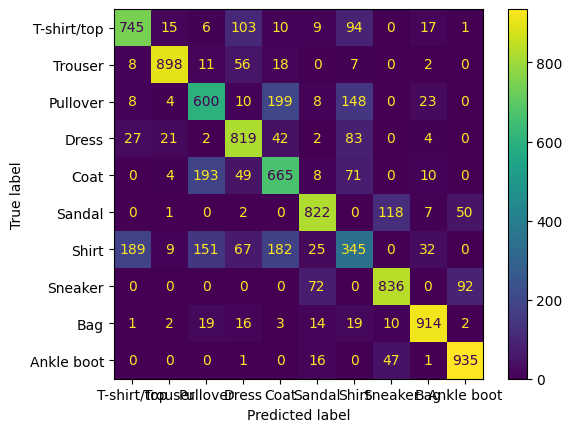

In [82]:
print("Accuracy:", accuracy_st)
print("Precision:", precision_st)
print("Recall:", recall_st)
print("F1 score: ", f1_score_st.cpu().item())

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_st,display_labels=validation.classes)
disp.plot()

## Part 4. Cluster-then-label

Cluster-then-label approaches form a group of methods that **explicitly join** the clustering and classification processes: they first apply an unsupervised or semi-supervised clustering algorithm to all available data, and use the resulting clusters to guide the classification process.

A simple example of a Cluster-then-label method:
- Cluster the data in a semi-supervised manner, favouring clusters with limited label impurity (i.e. a high degree of consistency in the labels of the data points within a given cluster),
- The unlabelled data points are then mapped, yielding a cluster assignment for each of them.
- If the cluster to which an unlabelled data point $x_i$ is mapped contains only data points with the same label, that label is also assigned to $x_i$.
- This process can be iterated, after which the resulting label assignments can be used to train a supervised classifier.

<u>Questions</u> (**3 points**):
1. Implement (manually) a function to apply the cluster-then-label algorithm, as previously stated.
- Use the same CNN from the aforementioned exercises.
- For each iteration, you must provide (at least) the following information:
  - The number of items added to the labelled data
  - The number of correctly / incorrectly classified items that are added to the labelled data
2. Try at least two different clustering algorithms and choose the best. Justify your decision.
3. With the best clustering algorithm, report the same evaluation metrics.

**Notes**:
- **DO NOT USE** any third-party implementation.

If the cluster to which an unlabelled data point xi is mapped contains only data points with the same label, that label is also assigned to xi.

  ## Semi-Supervised Clustering
  The idea for the algorithm is:

  1- Use the mean of labled data as the centroids to initialize kmeans, giving stability and fast convergence to the model

  2- Train the kmeans only with the labled data

  3- Classify unlabled datapoints using kmeans and assume that the ones that fall near the cluster centers or have confident predictions can be trusted, so add them as new labled datapoints

  4- Loop untill no more unlabled data is available or 0 items are added to labled data in that iteration

In [36]:
#Define the datasets we are going to use
#LABLED DATA
D_Labeled_imgs = np.array([img[0].view(-1).numpy() for img in D_Labeled])
D_Labeled_labels = [label[1] for label in D_Labeled]

#UNLABLED DATA
D_Unlabeled_imgs = np.array([img[0].view(-1).numpy() for img in D_Unlabeled_data])
D_Unlabeled_labels = [label[1] for label in D_Unlabeled_data]

total_imgs = np.concatenate((D_Labeled_imgs,D_Unlabeled_imgs))
total_labels = D_Labeled_labels + D_Unlabeled_labels

In [37]:
def compute_mean_centroids(DL_data, DL_labels,num_clusters,):
  '''Function to compute the initial centroids and leverage the labled data'''
  centroids = []
  for idx in range(num_clusters):
    indexes = np.where(np.array(DL_labels)==idx)
    centroid_imgs = DL_data[indexes[0]]
    centroid = np.mean(centroid_imgs, axis = 0)
    centroids.append(centroid)

  centroids = np.array(centroids)
  return centroids

In [38]:
def compute_cluster_purities(km_labels, DL_labels, num_clusters ):
  '''This function will return an ordered list with the purities of every cluster'''
  corrects = np.zeros(num_clusters)
  total = np.zeros(num_clusters)

  for (km_lab, true_lab) in zip(km_labels, DL_labels):
    total[km_lab] += 1
    if km_lab == true_lab:
      corrects[true_lab] += 1
  purities = np.divide(corrects, total)
  [print(f'LABEL: {idx}, CLUST_CORRECTS: {corr}, CLUST_TOTAL: {tot}, CLUST_PURITY: {purity}') for idx,corr, tot, purity in zip(range(num_clusters), corrects, total, purities)]
  return purities


### Computing which labels to add to the data
I got the idea of using closest points to the cluster centers of the data based on a percentile(defined by the threshold), form the following notebook, in the function "get_closest_data_points_to_cluster_centers"

https://www.kaggle.com/code/dhruv8680/semi-supervised-learning-mnist-dataset-kmeans

Notes:
1-In the original notebook uses the function np.percentile(), but it seems easier for me to apply it by hand in order to get the indices  
2- To reduce many last iterations adding few samples, when only 100 samples remain I assume that the model is almost trained, and I classify this last samples as the classes predicted at that iteration

In [39]:
def compute_new_labled_indices(kmeans,preds,DU_data, threshold):

  if DU_data.shape[0] >= 100:
    dists = np.linalg.norm(DU_data - kmeans.cluster_centers_[preds], axis =1)
    indices = np.argsort(dists)[:int(len(dists)*(1-threshold))]
  else:
    indices = range(DU_data.shape[0])
  print(f'NUMBER OF ITEMS ADDED TO LABLED DATA: {len(indices)}')

  return indices

In [40]:
def compute_correct_additions(indices,preds, DU_labels, totals_by_class, corrects_by_class):
  new_real_DL_labels = []
  total = 0
  corrects = 0
  for idx in indices:
    new_real_DL_labels.append(DU_labels[idx])
    totals_by_class[DU_labels[idx]] += 1
    total += 1
    if DU_labels[idx] == preds[idx]:
          corrects +=1
          corrects_by_class[DU_labels[idx]] += 1

  new_DU_labels = np.delete(np.array(DU_labels), indices)

  print(f'NUMBER OF CORRECTLY CLASSIFYED: {corrects}')
  print(f'NUMBER OF INCORRECTLY CLASSIFYED. {total - corrects}')

  added_purities = np.divide(corrects_by_class, totals_by_class)
  [print(f'LABEL: {idx}, CORRECTLY_ADDED: {corr}, TOTAL_ADDED: {tot}, ACCURACY: {purity}') for idx,corr, tot, purity in zip(range(len(totals_by_class)), corrects_by_class, totals_by_class, added_purities)]
  return new_real_DL_labels, new_DU_labels, corrects_by_class, totals_by_class

In [41]:
def new_labled_data(indices, preds, DU_data):
  new_DL_data = []
  new_pseudolabels = []

  for idx in indices:
    new_DL_data.append(DU_data[idx])
    new_pseudolabels.append(preds[idx])

  #Delete all data that has been pseudo-labled
  new_DU_data = np.delete(DU_data, indices, axis = 0 )
  new_DL_data = np.array(new_DL_data)

  return new_DL_data, new_pseudolabels, new_DU_data

In [42]:
from sklearn.cluster import KMeans
def semi_supervised_kmeans(DL_data, DL_labels, DU_data, DU_labels, num_clusters, threshold):
  iterations = 0
  corrects_by_class = np.zeros(num_clusters)
  totals_by_class = np.zeros(num_clusters)
  real_DL_labels = DL_labels

  while not DU_data.shape[0] == 0:
    print(f'ITERATION: {iterations} THRESHOLD: {threshold}')
    centroids = compute_mean_centroids(DL_data,DL_labels, num_clusters)
    kmeans = KMeans(n_clusters=num_clusters,init = centroids,n_init = 1, random_state=0,max_iter=1000).fit(DL_data)
    preds = kmeans.predict(DU_data)
    km_labels = kmeans.labels_ #As predefined centroids are provided ordered by classes, the centroids_ids and labels will match(The centroid_id = 1 will be label = 1 in the labled data )
    print("PSEUDOLABLED PURITIES: ")
    purities = compute_cluster_purities(km_labels,DL_labels, num_clusters)
    print("REAL PURITIES: ")
    purities = compute_cluster_purities(km_labels,real_DL_labels, num_clusters)

    #Compute new pseudo-labled data
    indices = compute_new_labled_indices(kmeans,preds,DU_data, threshold)
    new_real_DL_labels,DU_labels, corrects_by_class, totals_by_class = compute_correct_additions(indices,preds, DU_labels, totals_by_class, corrects_by_class)
    new_data, new_labels, DU_data = new_labled_data(indices, preds,DU_data)

    #Merge the new pseudo-labled data with the already labled data
    if new_data.shape[0] != 0:
      DL_data = np.concatenate((DL_data,new_data))#error
    DL_labels = DL_labels + new_labels
    real_DL_labels = real_DL_labels + new_real_DL_labels

    iterations += 1
    print("\n")
  return kmeans,DL_data, DL_labels, DU_data, DU_labels


#GMM

In [43]:
def new_labled_data(indices, preds, DU_data):
  new_DL_data = []
  new_pseudolabels = []

  for idx in indices:
    new_DL_data.append(DU_data[idx])
    new_pseudolabels.append(preds[idx])

  #Delete all data that has been pseudo-labled
  new_DU_data = np.delete(DU_data, indices, axis = 0 )
  new_DL_data = np.array(new_DL_data)

  return new_DL_data, new_pseudolabels, new_DU_data

In [44]:
def compute_covariance_centroids(DL_data, DL_labels,num_clusters):
  '''Function to compute the initial centroids and leverage the labled data'''
  covs = []
  for idx in range(num_clusters):
    indexes = np.where(np.array(DL_labels)==idx)
    centroid_imgs = DL_data[indexes[0]]
    cov = np.linalg.inv(np.cov(centroid_imgs, rowvar=False))
    covs.append(cov)
  covs = np.array(covs)
  return covs

In [45]:
def compute_new_labled_indices_GMM(GMM,preds,DU_data):
  probs = GMM.predict_proba(DU_data)

  max_probs = np.max(probs, axis = 1)
  indices = np.argsort(max_probs)[:5000]
  print(f'NUMBER OF ITEMS ADDED TO LABLED DATA: {len(indices)}')

  return indices

## Gaussian Mixtures
The strategy for this semi-supervised clustering is at each iteration add the 5000 first most confident samples, so that ones with higher probabilities of being produced by certain gaussian.

Note:
1-In the Gaussian mixtures we must apply data dimensionality reduction to speed up the model, and to be able to compute the starting inverses of the  covariance matrices, because with the full features of the data the matrices have no inverse.

2-I tried to use a threshold to select the samples that exeeded that threshold at every iteration, but the results where worst,and needed

In [46]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
def semi_supervised_GMM(DL_data, DL_labels, DU_data, DU_labels, num_clusters):

  iterations = 0
  corrects_by_class = np.zeros(num_clusters)
  totals_by_class = np.zeros(num_clusters)
  real_DL_labels = DL_labels


  while not DU_data.shape[0] == 0:
    print(f'ITERATION: {iterations}')
    DL_data = PCA(n_components=50).fit_transform(DL_data)
    DU_data = PCA(n_components=50).fit_transform(DU_data)
    init_precisions = compute_covariance_centroids(DL_data, DL_labels,num_clusters)
    centroids = compute_mean_centroids(DL_data,DL_labels, num_clusters)

    GMM = GaussianMixture(n_components=num_clusters,means_init = centroids,precisions_init = init_precisions, n_init = 1, random_state=0).fit(DL_data)
    preds = GMM.predict(DU_data)
    GMM_labels = GMM.predict(DL_data) #As predefined centroids are provided ordered by classes, the centroids_ids and labels will match(The centroid_id = 1 will be label = 1 in the labled data )
    print("PSEUDOLABLED PURITIES: ")
    pseudo_purities = compute_cluster_purities(GMM_labels,DL_labels, num_clusters)
    print("REAL PURITIES: ")
    real_purities = compute_cluster_purities(GMM_labels,real_DL_labels, num_clusters)

    #Compute new pseudo-labled data
    indices = compute_new_labled_indices_GMM(GMM,preds,DU_data)
    new_real_DL_labels,DU_labels, corrects_by_class, totals_by_class = compute_correct_additions(indices,preds, DU_labels, totals_by_class, corrects_by_class)
    new_data, new_labels, DU_data = new_labled_data(indices, preds,DU_data)

    #Merge the new pseudo-labled data with the already labled data
    if new_data.shape[0] != 0:
      DL_data = np.concatenate((DL_data,new_data))#error
    DL_labels = DL_labels + new_labels
    real_DL_labels = real_DL_labels + new_real_DL_labels

    iterations += 1
    print("\n")
  return GMM,DL_data, DL_labels, DU_data, DU_labels


##Training the models

###Gaussian Mixtures

Without looping(only initializing parameters and doing 1 iteration)

In [47]:
num_clusters = 10
GMM_data_lab = PCA(n_components=50).fit_transform(D_Labeled_imgs)
GMM_data_unlab = PCA(n_components=50).fit_transform(D_Unlabeled_imgs)
centroids = compute_mean_centroids(GMM_data_lab, D_Labeled_labels, num_clusters)
init_precisions = compute_covariance_centroids(GMM_data_lab, D_Labeled_labels,num_clusters)
simple_GMM = GaussianMixture(n_components=num_clusters,means_init = centroids, n_init = 1).fit(GMM_data_unlab)
simple_preds_GMM = simple_GMM.predict(GMM_data_unlab)
_ = compute_cluster_purities(simple_preds_GMM, total_labels, num_clusters )

LABEL: 0, CLUST_CORRECTS: 1450.0, CLUST_TOTAL: 14167.0, CLUST_PURITY: 0.10235053292863697
LABEL: 1, CLUST_CORRECTS: 0.0, CLUST_TOTAL: 0.0, CLUST_PURITY: nan
LABEL: 2, CLUST_CORRECTS: 771.0, CLUST_TOTAL: 7531.0, CLUST_PURITY: 0.10237684238480946
LABEL: 3, CLUST_CORRECTS: 0.0, CLUST_TOTAL: 0.0, CLUST_PURITY: nan
LABEL: 4, CLUST_CORRECTS: 0.0, CLUST_TOTAL: 0.0, CLUST_PURITY: nan
LABEL: 5, CLUST_CORRECTS: 596.0, CLUST_TOTAL: 5652.0, CLUST_PURITY: 0.10544939844302902
LABEL: 6, CLUST_CORRECTS: 1173.0, CLUST_TOTAL: 11897.0, CLUST_PURITY: 0.09859628477767504
LABEL: 7, CLUST_CORRECTS: 456.0, CLUST_TOTAL: 4545.0, CLUST_PURITY: 0.10033003300330033
LABEL: 8, CLUST_CORRECTS: 0.0, CLUST_TOTAL: 0.0, CLUST_PURITY: nan
LABEL: 9, CLUST_CORRECTS: 641.0, CLUST_TOTAL: 6208.0, CLUST_PURITY: 0.10325386597938144


<ipython-input-38-52ff59aea490>:10: RuntimeWarning: invalid value encountered in divide
  purities = np.divide(corrects, total)


With self training loop

In [48]:
num_clusters = 10
GMM_model,DL_data_GMM, DL_labels_GMM, DU_data_GMM, DU_labels_GMM = semi_supervised_GMM(D_Labeled_imgs, D_Labeled_labels, D_Unlabeled_imgs, D_Unlabled_labels, num_clusters)

ITERATION: 0
PSEUDOLABLED PURITIES: 
LABEL: 0, CLUST_CORRECTS: 678.0, CLUST_TOTAL: 877.0, CLUST_PURITY: 0.7730900798175598
LABEL: 1, CLUST_CORRECTS: 846.0, CLUST_TOTAL: 1045.0, CLUST_PURITY: 0.8095693779904306
LABEL: 2, CLUST_CORRECTS: 476.0, CLUST_TOTAL: 839.0, CLUST_PURITY: 0.567342073897497
LABEL: 3, CLUST_CORRECTS: 666.0, CLUST_TOTAL: 1138.0, CLUST_PURITY: 0.5852372583479789
LABEL: 4, CLUST_CORRECTS: 525.0, CLUST_TOTAL: 1220.0, CLUST_PURITY: 0.430327868852459
LABEL: 5, CLUST_CORRECTS: 429.0, CLUST_TOTAL: 656.0, CLUST_PURITY: 0.6539634146341463
LABEL: 6, CLUST_CORRECTS: 278.0, CLUST_TOTAL: 1125.0, CLUST_PURITY: 0.24711111111111111
LABEL: 7, CLUST_CORRECTS: 874.0, CLUST_TOTAL: 1601.0, CLUST_PURITY: 0.5459088069956277
LABEL: 8, CLUST_CORRECTS: 765.0, CLUST_TOTAL: 791.0, CLUST_PURITY: 0.9671302149178256
LABEL: 9, CLUST_CORRECTS: 697.0, CLUST_TOTAL: 708.0, CLUST_PURITY: 0.9844632768361582
REAL PURITIES: 
LABEL: 0, CLUST_CORRECTS: 678.0, CLUST_TOTAL: 877.0, CLUST_PURITY: 0.77309007981755

### Kmeans

Without looping(only initializing parameters and doing 1 iteration)

In [49]:
num_clusters = 10
centroids = compute_mean_centroids(D_Labeled_imgs, D_Labeled_labels, num_clusters)
simple_kmeans = KMeans(n_clusters=num_clusters,init = centroids,n_init = 1, random_state=0,max_iter=1000).fit(total_imgs)
simple_preds = simple_kmeans.predict(total_imgs)
_ = compute_cluster_purities(simple_preds, total_labels, num_clusters )

LABEL: 0, CLUST_CORRECTS: 3285.0, CLUST_TOTAL: 6050.0, CLUST_PURITY: 0.5429752066115703
LABEL: 1, CLUST_CORRECTS: 5193.0, CLUST_TOTAL: 5252.0, CLUST_PURITY: 0.9887661843107388
LABEL: 2, CLUST_CORRECTS: 1934.0, CLUST_TOTAL: 4271.0, CLUST_PURITY: 0.45282135331304146
LABEL: 3, CLUST_CORRECTS: 3929.0, CLUST_TOTAL: 5209.0, CLUST_PURITY: 0.7542714532539835
LABEL: 4, CLUST_CORRECTS: 2977.0, CLUST_TOTAL: 6085.0, CLUST_PURITY: 0.4892358258011504
LABEL: 5, CLUST_CORRECTS: 3922.0, CLUST_TOTAL: 7881.0, CLUST_PURITY: 0.49765258215962443
LABEL: 6, CLUST_CORRECTS: 1962.0, CLUST_TOTAL: 8009.0, CLUST_PURITY: 0.2449744037957298
LABEL: 7, CLUST_CORRECTS: 5101.0, CLUST_TOTAL: 7702.0, CLUST_PURITY: 0.662295507660348
LABEL: 8, CLUST_CORRECTS: 3523.0, CLUST_TOTAL: 3717.0, CLUST_PURITY: 0.9478073715361851
LABEL: 9, CLUST_CORRECTS: 5029.0, CLUST_TOTAL: 5824.0, CLUST_PURITY: 0.8634958791208791


With self training loop

In [50]:
threshold = 0.8
num_clusters = 10
kmeans_model,DL_data_km, DL_labels_km, DU_data_km, DU_labels_km = semi_supervised_kmeans(D_Labeled_imgs, D_Labeled_labels, D_Unlabeled_imgs, D_Unlabled_labels, num_clusters, threshold)

ITERATION: 0 THRESHOLD: 0.8
PSEUDOLABLED PURITIES: 
LABEL: 0, CLUST_CORRECTS: 547.0, CLUST_TOTAL: 1012.0, CLUST_PURITY: 0.5405138339920948
LABEL: 1, CLUST_CORRECTS: 883.0, CLUST_TOTAL: 889.0, CLUST_PURITY: 0.9932508436445444
LABEL: 2, CLUST_CORRECTS: 307.0, CLUST_TOTAL: 698.0, CLUST_PURITY: 0.43982808022922637
LABEL: 3, CLUST_CORRECTS: 659.0, CLUST_TOTAL: 882.0, CLUST_PURITY: 0.7471655328798186
LABEL: 4, CLUST_CORRECTS: 559.0, CLUST_TOTAL: 1091.0, CLUST_PURITY: 0.5123739688359303
LABEL: 5, CLUST_CORRECTS: 645.0, CLUST_TOTAL: 1249.0, CLUST_PURITY: 0.5164131305044035
LABEL: 6, CLUST_CORRECTS: 334.0, CLUST_TOTAL: 1300.0, CLUST_PURITY: 0.2569230769230769
LABEL: 7, CLUST_CORRECTS: 807.0, CLUST_TOTAL: 1244.0, CLUST_PURITY: 0.6487138263665595
LABEL: 8, CLUST_CORRECTS: 564.0, CLUST_TOTAL: 600.0, CLUST_PURITY: 0.94
LABEL: 9, CLUST_CORRECTS: 905.0, CLUST_TOTAL: 1035.0, CLUST_PURITY: 0.8743961352657005
REAL PURITIES: 
LABEL: 0, CLUST_CORRECTS: 547.0, CLUST_TOTAL: 1012.0, CLUST_PURITY: 0.540513833

##Test the models


In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred_kmeans = kmeans_model.predict(total_imgs)
accuracy_kmeans = accuracy_score(total_labels, y_pred_kmeans)
precision_kmeans = precision_score(total_labels, y_pred_kmeans, average='weighted')
recall_kmeans = recall_score(total_labels, y_pred_kmeans, average='weighted')
f1_kmeans = f1_score(total_labels, y_pred_kmeans, average='weighted')
confusion_matrix_kmeans = confusion_matrix(total_labels, y_pred_kmeans)

KMEANS Metrics:
Accuracy: 0.5921166666666666
Precision: 0.6195432039378416
Recall: 0.5921166666666666
F1_score: 0.5934945976654054


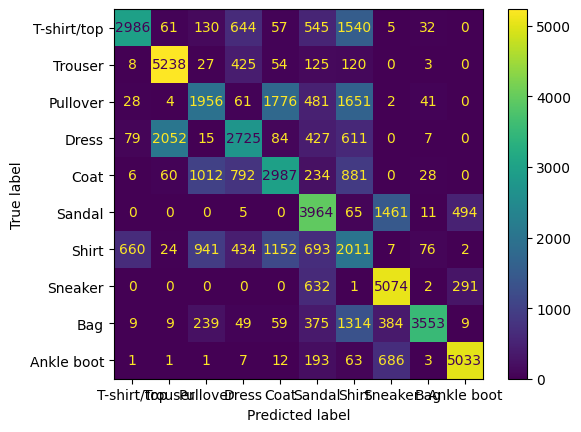

In [52]:
print("KMEANS Metrics:")
print("Accuracy:", accuracy_kmeans)
print("Precision:", precision_kmeans)
print("Recall:", recall_kmeans)
print("F1_score:", f1_kmeans)


disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_kmeans,display_labels=validation.classes)
disp.plot()

In [53]:
y_pred_kmeans = simple_kmeans.predict(total_imgs)
accuracy_skmeans = accuracy_score(total_labels, y_pred_kmeans)
precision_skmeans = precision_score(total_labels, y_pred_kmeans, average='weighted')
recall_skmeans = recall_score(total_labels, y_pred_kmeans, average='weighted')
f1_skmeans = f1_score(total_labels, y_pred_kmeans, average='weighted')
confusion_matrix_skmeans = confusion_matrix(total_labels, y_pred_kmeans)

KMEANS Metrics:
Accuracy: 0.61425
Precision: 0.644429576756325
Recall: 0.61425
F1_score: 0.620410022838302


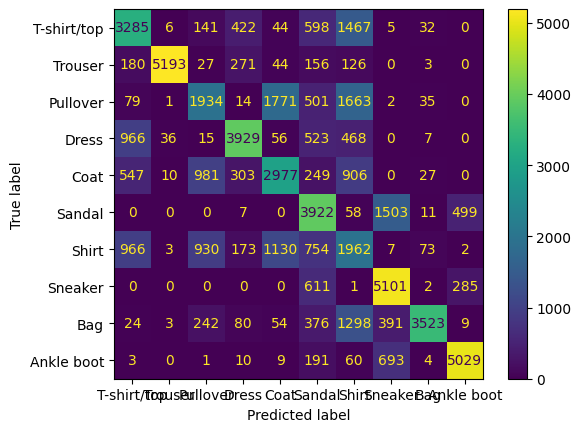

In [54]:
print("KMEANS Metrics:")
print("Accuracy:", accuracy_skmeans)
print("Precision:", precision_skmeans)
print("Recall:", recall_skmeans)
print("F1_score:", f1_skmeans)


disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_skmeans,display_labels=validation.classes)
disp.plot()

In [55]:
gmm_data = PCA(n_components=50).fit_transform(total_imgs)
y_pred_GMM = simple_GMM.predict(gmm_data)

In [56]:
accuracy_sGMM = accuracy_score(total_labels, y_pred_GMM)
precision_sGMM = precision_score(total_labels, y_pred_GMM, average='weighted')
recall_sGMM = recall_score(total_labels, y_pred_GMM, average='weighted')
f1_sGMM = f1_score(total_labels, y_pred_GMM, average='weighted')
confusion_matrix_sGMM = confusion_matrix(total_labels, y_pred_GMM)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Gaussian Mixtures Metrics:
Accuracy: 0.15973333333333334
Precision: 0.1624957118823149
Recall: 0.15973333333333334
F1_score: 0.08025899391140981


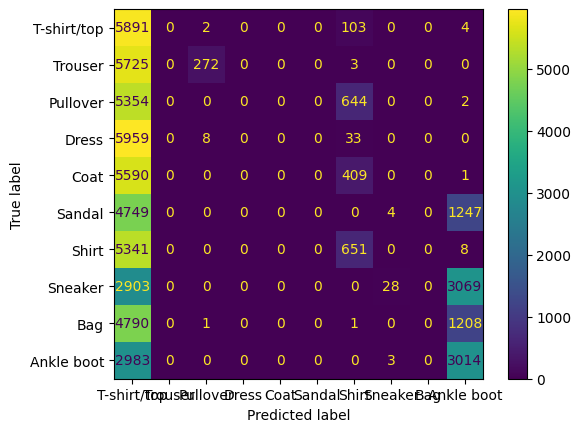

In [57]:
print("Gaussian Mixtures Metrics:")
print("Accuracy:", accuracy_sGMM)
print("Precision:", precision_sGMM)
print("Recall:", recall_sGMM)
print("F1_score:", f1_sGMM)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_sGMM,display_labels=validation.classes)
disp.plot()

In [58]:
gmm_data = PCA(n_components=50).fit_transform(total_imgs)
y_pred_GMM = GMM_model.predict(gmm_data)

In [59]:
accuracy_GMM = accuracy_score(total_labels, y_pred_GMM)
precision_GMM = precision_score(total_labels, y_pred_GMM, average='weighted')
recall_GMM = recall_score(total_labels, y_pred_GMM, average='weighted')
f1_GMM = f1_score(total_labels, y_pred_GMM, average='weighted')
confusion_matrix_GMM = confusion_matrix(total_labels, y_pred_GMM)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Gaussian Mixtures Metrics:
Accuracy: 0.1
Precision: 0.010008173341562277
Recall: 0.1
F1_score: 0.018195326833558248


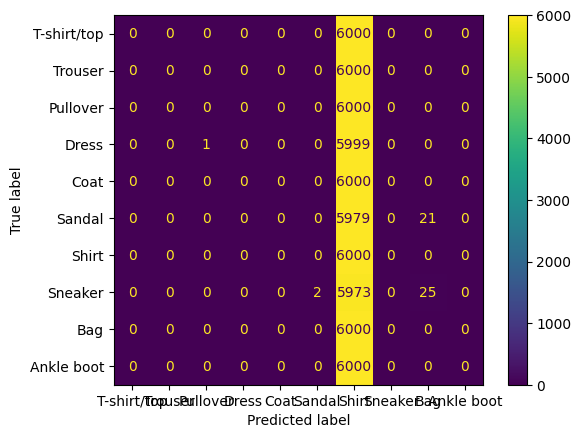

In [60]:
print("Gaussian Mixtures Metrics:")
print("Accuracy:", accuracy_GMM)
print("Precision:", precision_GMM)
print("Recall:", recall_GMM)
print("F1_score:", f1_GMM)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_GMM,display_labels=validation.classes)
disp.plot()

The choosen models are:
kmeans: Because it's a simple model that is capable to handle big datasets, recieving a fast response, specially when dealing with this iteration process this computation time is an important factor.

Gaussian Mixtures: I tried gaussian mixtures because I thougt that could be a more expressive model in order to model the "complex" dataset as images can be

I finally choose the kmeans because it's the one that provided a decent classification of about 0.6, and with not any class clearly poorly classifyed

Notes: The Gaussian Mixtures had a huge problem, because despite initilizing the parameters the model always created an overrepresented classs where all the lables ended(shirt). Notice that the purity of the other labels are not bad, but because of the overrepresentation of the shirt class when adding pseudolabels, all the new samples are classifyed as shirt. At the last iteration the shirt class had arround 42000 of the 60000 samples on it


The kmeans without iteration model is the one that had better results in all the scores, so to train the CNN we are going to use the kmeans cluster predicts

KMEANS Metrics:
Accuracy: 0.61425
Precision: 0.644429576756325
Recall: 0.61425
F1_score: 0.620410022838302


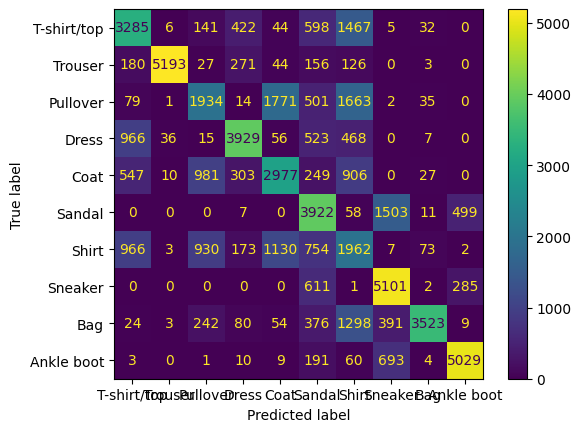

In [61]:
print("KMEANS Metrics:")
print("Accuracy:", accuracy_skmeans)
print("Precision:", precision_skmeans)
print("Recall:", recall_skmeans)
print("F1_score:", f1_skmeans)


disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_skmeans,display_labels=validation.classes)
disp.plot()

##CNN

### Define data loaders

In [62]:
batch_size = 100
dataset = []
y_pred_kmeans = simple_kmeans.predict(total_imgs)
y_pred_kmeans = torch.tensor(y_pred_kmeans).type(torch.LongTensor)
for img, pred_lab in zip(total_imgs, y_pred_kmeans) :
  dataset.append((torch.tensor(img).view(1,28,28),pred_lab))

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_loader =  torch.utils.data.DataLoader(validation, batch_size=batch_size, shuffle=True)


In [63]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features = 144*16, out_features  = 10)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size = 5),#24x24x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),#12x12x16

        )


    def forward(self, x):
        batch_size = x.shape[0]
        x = self.encoder(x.squeeze(0))

        x = x.view(batch_size,-1)

        x = self.fc1(x)

        return x

In [64]:
model_km = CNN().to(device)


optimizer = torch.optim.SGD(model_km.parameters(), lr=1e-3)


criterion = nn.CrossEntropyLoss()

In [65]:
epochs=5
for epoch in range(epochs):
    model_train(model_km, train_loader, optimizer, criterion, reshape=True)
    tot_pred_labels,tot_true_labels = model_test(model_km, val_loader, criterion, reshape=True)

epoch : 1/5, Train loss = 2.004672
epoch : 1/5, Test loss = 1.696162
epoch : 2/5, Train loss = 1.133176
epoch : 2/5, Test loss = 1.110947
epoch : 3/5, Train loss = 0.654154
epoch : 3/5, Test loss = 1.023982
epoch : 4/5, Train loss = 0.467812
epoch : 4/5, Test loss = 1.067563
epoch : 5/5, Train loss = 0.376891
epoch : 5/5, Test loss = 1.146708


In [66]:
num_correct_preds = torch.sum(torch.eq(tot_true_labels,tot_pred_labels)).item()
accuracy_clust = num_correct_preds/len(tot_true_labels)
precision_clust = precision_score(tot_true_labels.cpu(), tot_pred_labels.cpu(), average='weighted')
recall_clust = recall_score(tot_true_labels.cpu(), tot_pred_labels.cpu(), average='weighted')
f1_score_clust = multiclass_f1_score(tot_pred_labels,tot_true_labels)
confusion_clust = confusion_matrix(tot_true_labels.cpu(),tot_pred_labels.cpu() )

Accuracy: 0.6261
Precision: 0.6580314063606922
Recall: 0.6261
F1 score:  0.6261000037193298


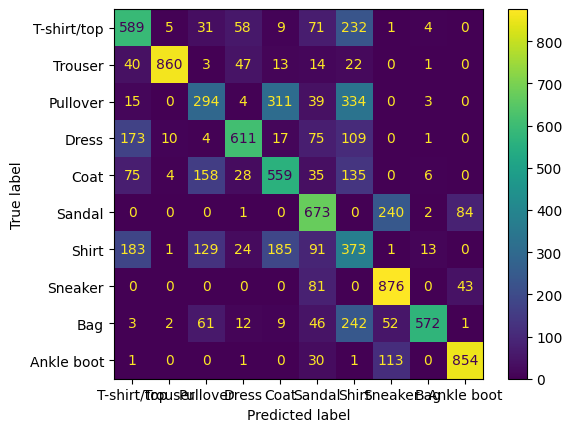

In [67]:
print("Accuracy:", accuracy_clust)
print("Precision:", precision_clust)
print("Recall:", recall_clust)
print("F1 score: ", f1_score_clust.cpu().item())

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_clust,display_labels=validation.classes)
disp.plot()

## Part 5.

This last part of the exercise is theoretical and does not involve code execution.

<u>Questions</u> (1 point):
1. Provide a comparison, with data and plots, among the four alternatives we have developed to solve the problem.
2. Justify, based on the data, which of the semi-supervised methods is the best.

Accuracy: 0.7578
Precision: 0.7514228841522157
Recall: 0.7578
F1 score:  0.7577999830245972


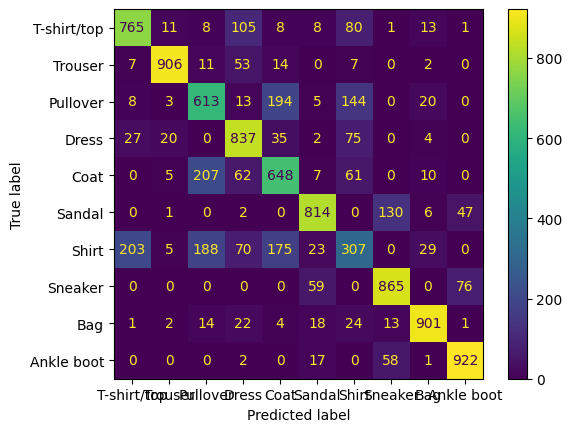

In [68]:
print("Accuracy:", accuracy_60000)
print("Precision:", precision_60000)
print("Recall:", recall_60000)
print("F1 score: ", f1_score_60000.cpu().item())

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_60000,display_labels=validation.classes)
disp.plot()

Accuracy: 0.5751
Precision: 0.6300371556691248
Recall: 0.5751
F1 score:  0.5751000046730042


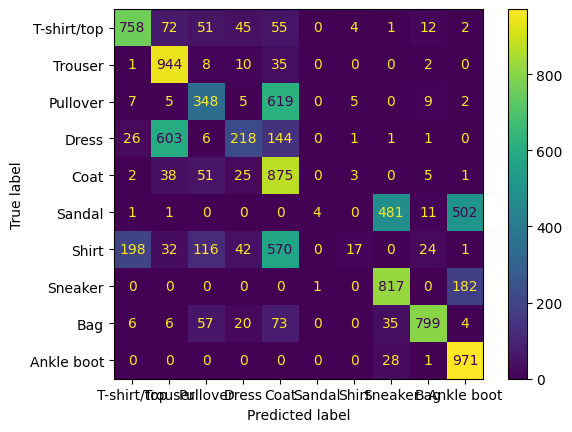

In [69]:
print("Accuracy:", accuracy_10000)
print("Precision:", precision_10000)
print("Recall:", recall_10000)
print("F1 score: ", f1_score_10000.cpu().item())

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_10000,display_labels=validation.classes)
disp.plot()

Accuracy: 0.7609
Precision: 0.7566405806947596
Recall: 0.7609
F1 score:  0.7609000205993652


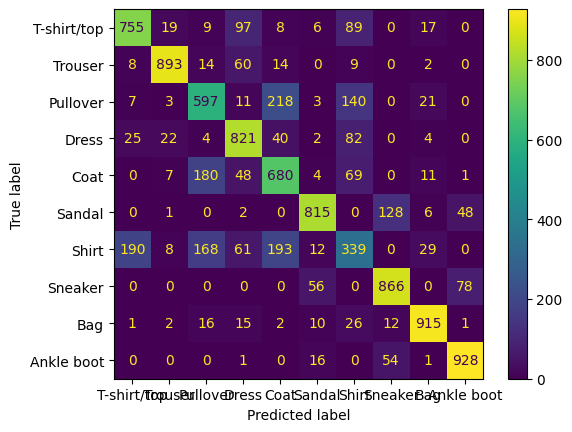

In [70]:
print("Accuracy:", accuracy_st)
print("Precision:", precision_st)
print("Recall:", recall_st)
print("F1 score: ", f1_score_st.cpu().item())

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_st,display_labels=validation.classes)
disp.plot()

Accuracy: 0.6261
Precision: 0.6580314063606922
Recall: 0.6261
F1 score:  0.6261000037193298


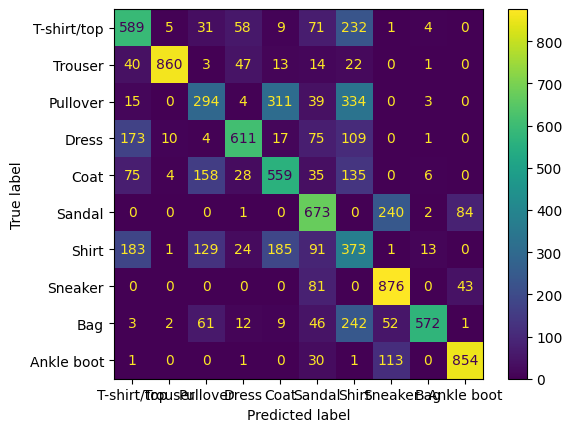

In [71]:
print("Accuracy:", accuracy_clust)
print("Precision:", precision_clust)
print("Recall:", recall_clust)
print("F1 score: ", f1_score_clust.cpu().item())

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_clust,display_labels=validation.classes)
disp.plot()

2. Justify, based on the data, which of the semi-supervised methods is the best.

We can conclude that the best alternative is the **self-supervised** method because it achieves better results in all the general metrics. Despite that if we look at the confusion matrix, we can see that it's the only one that achieve good scores for all the classes, and don't have a class that is clearly poorly classifyed.

It's worth to notice that the 2  supervised methods always there's a class that is poorly classifyed over the others, but in the semi-supervised methods all there's not a clearly missclassifiyed class.

The self-supervised is probably better because it learn new labels from the CNN, a model with high flexibility, good for "complex" data as can be images.
In the method of cluster-then-label, as I used kmeans the data can only be grouped in circular regions, using the mean as the only criterion. In summary the kmeans is a model with some lack of flexibility to correctly classfy such a "complex" dataset as an image dataset can be.